##### PyMC3 Examples

# Model Selection - Bayes Factor

@author: Jonathan Sedar  
@email: jon@sedar.co  
@date: Mon 28 Dec 2015  

**A minimal reproducable example of Model Selection using Bayes Factor.**

+ This example evaluates two different regression models and declares which has the better fit according to a Bayes Factor comparison.
+ The example is adapted specifically from Jake Vanderplas' [recent blogpost](https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/) on model selection, for which he used an emcee sampler and numpy-based likelihood. The main purpose of this Notebook is to create a PyMC3-based version.
+ The dataset is tiny and generated within this Notebook. It contains errors in the measured value (y) only.


**Note:**

+ Python 3.4 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.  
+ Finally, if runs become unstable or Theano throws weird errors, try clearing the cache `$> theano-cache clear` and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.4
      - ipython
      - ipython-notebook
      - ipython-qtconsole
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip

$> conda env create --file conda_env_pymc3_examples.yml

$> source activate pymc3_examples

$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```

# Setup

In [1]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano as thno
import theano.tensor as T 

from IPython.html.widgets import interactive, fixed

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
rndst = np.random.RandomState(0)

## Local Functions

In [58]:
def generate_data(n=20, p=0, a=1, b=1, c=0, latent_sigma_y=20):
    '''
    Create an example dataset based on a very simple model that we might
    imagine is a noisy physical process:
        1. random x values within a range
        2. latent error aka inherent noise in y
        3. optional outliers from unknown sources

    Model form: y ~ a + bx + cx^2 + e
    
    NOTE: latent_sigma_y is used to create a normally distributed,
    'latent error' aka 'inherent noise' in the 'physical process' 
    generating thses values, rather than experimental measurement error. 
    Please don't use the returned `latent_error` values in inferential 
    models, it's there for interest only.
    '''
    
    df = pd.DataFrame({'x':rndst.uniform(0,100,n)})
    df['latent_error'] = rndst.normal(0,latent_sigma_y,n)
    df['outlier'] = rndst.binomial(1,p,n)

    bimdl = np.append(rndst.normal(-.4,0.1,100), np.random.normal(.4,0.1,100))
    df['outlier_adj'] = rndst.choice(bimdl, n, replace=False)
                
    ## create linear model
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 + df['latent_error']
   
    ## add extreme noise for outliers
    df['y'] = df['y'] + (df['outlier'] * df['outlier_adj'] * df['y'])

    ## round and return
    for col in ['y','latent_error','x','outlier_adj']:
        df[col] = np.round(df[col],3)
       
    return df


def sketch_data(n=20, p=0, a=-30, b=5, c=0):
    ''' Sketch the generated data '''
    
    df = generate_data(n, p, a, b, c)
    ordr = 'linear' if c == 0 else 'quadratic'
    
    g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

    _ = g.map(plt.errorbar, 'x', 'y', 'latent_error', marker="o"
              , ls='', elinewidth=0.7).add_legend()

    plotx = np.linspace(df['x'].min() - np.ptp(df['x'])*.1
                        ,df['x'].max() + np.ptp(df['x'])*.1, 100)
    ploty = a + b*plotx + c*plotx**2

    _ = plt.plot(plotx,ploty,'--',alpha=0.8)
    plt.subplots_adjust(top=0.92)
    _ = g.fig.suptitle('Sketch of Data Generation ({})'.format(ordr)
                       , fontsize=16)

## Draft Data

We'll generate a dummy dataset based on a specific distribution, so we can better evaluate the correctness of the automated model selection later.

Use the interactive plot below to get a feel for the possibilities of data we could generate.

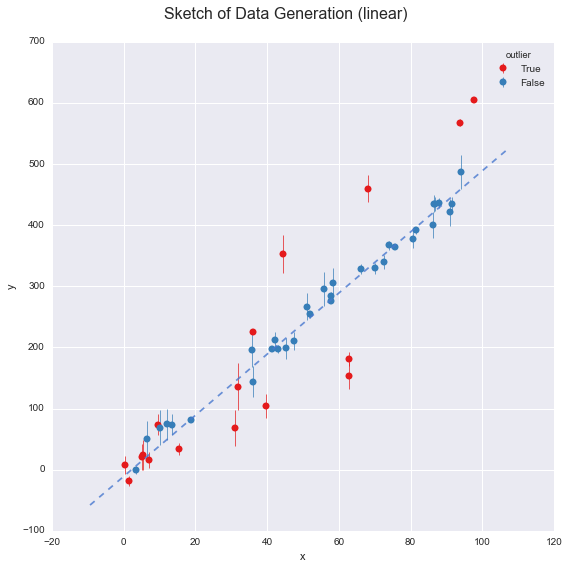

In [60]:
interactive(sketch_data, n=[5,50,5], p=[0,.5,.05], a=[-50,50], b=[-10,10], c=[-10,10])

**Observe:**

+ I've shown the `latent_error` in errorbars, but this is for interest only, since this shows the _inherent noise_ in whatever 'physical process' we imagine created the data.
+ There is no _measurement error_.
+ Datapoints created as outliers are shown in **red**, again for interest only.

## Create Dataset for Modelling

We can use the above interactive plot to get a feel for the effect of the params. Now I'll create a fixed dataset to use for the remainder of the Notebook. 

For a start, I'll create a linear model with no outliers. Keep it simple.

In [48]:
a, b, latent_sigma_y = -30, 5, 20
df = generate_data(a=a, b=b, latent_sigma_y=latent_sigma_y)

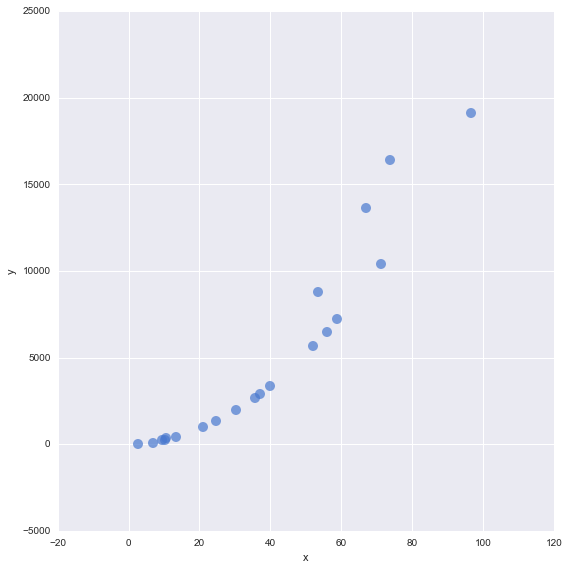

In [46]:
g = sns.lmplot(x='x', y='y', data=df, fit_reg=False, size=8
               ,scatter_kws={'alpha':0.7,'s':100})

**Observe:**

+ This then, is out dataset for the remainder of the notebook. Let's see how well we can fit it!

---

# Create Conventional OLS Model

The *linear model* is really simple and conventional:
$$\bf{y} = \beta^{T} \bf{X} + \bf{\sigma}$$
where:  

$\beta$ = coefs = $\{1, \beta_{j \in X_{j}}\}$  
$\sigma$ = unknown error in the dataset

##### Define model

In [18]:
with pm.Model() as mdl_ols:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)
 
    ## Define linear model
    yest = b0 + b1 * df['x']

    ## Define Normal likelihood with HalfNormal noise
    sigma_y = pm.HalfNormal('sigma_y', sd=100)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=df['y'])


##### Sample

In [19]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 98.916257
         Iterations: 10
         Function evaluations: 379
 [-----------------100%-----------------] 2000 of 2000 complete in 2.9 sec

##### View Traces

**NOTE**: I'll 'burn' the traces to only retain the final 1000 samples

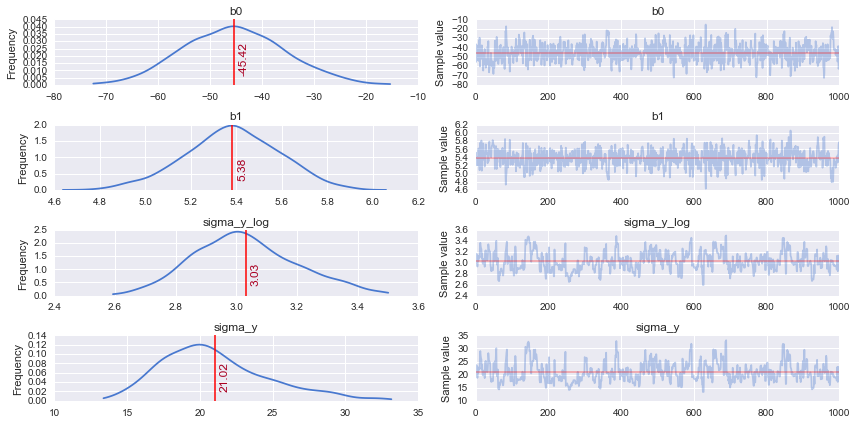

In [20]:
kp = 1000
ax = pm.traceplot(traces_ols[-kp:], figsize=(12,len(traces_ols.varnames)*1.5),
                lines={k: v['mean'] for k, v in pm.df_summary(traces_ols[-kp:]).iterrows()})

for i, mn in enumerate(pm.df_summary(traces_ols[-kp:])['mean']):
    ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points'
                    ,rotation=90, va='bottom', fontsize='large', color='#AA0022')

**Observe:**

+ This simple OLS manages to make pretty good guesses for b1_mean = 5.38 (b1_true = 5) and sigma_y = 21.02 (sigma_y_true = 20), but the estimate is poor for b0_mean = -45.42 (b0_true = 45.42).
+ The simple OLS seems to have been thrown off by noise


---

# Create Higher-Order OLS Models

##### View Posterior Predictive Fit

In [ ]:
g = sns.FacetGrid(df, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0'] + samp['b1'] * x
xrng = df['x'].max() - df['x'].min()

pm.glm.plot_posterior_predictive(traces_ols[-1000:]
        ,eval=np.linspace(df['x'].min() - np.ptp(df['x'])/10
                        ,df['x'].max() + np.ptp(df['x'])/10, 10)
        ,lm=lm, samples=200, color='#00AA00', alpha=.1)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', marker="o", ls='').add_legend()


plotx = np.linspace(df['x'].min() - np.ptp(df['x'])/10
                        ,df['x'].max() + np.ptp(df['x'])/10, 10)
ploty = -30 + 5* plotx

_ = plt.plot(plotx,ploty)

In [ ]:
df['sigma_y'].plot(kind='kde')

---

---

# next

---